In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python import debug as tf_debug
from datetime import datetime
import _pickle as cPickle
import os
import time
import shutil
from pathlib import Path
#%load_ext autotime
%matplotlib inline

/home/gabriel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/gabriel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
#0.0008
flags.DEFINE_float('learning_rate', 0.0008, 'Initial learning rate.')#0.0008
flags.DEFINE_integer('max_steps', 20000, 'Number of iteration to train.')
flags.DEFINE_integer('number_layers', 3, 'Number of layers in each network')
flags.DEFINE_integer('layer_sizes', 256, 'Number of units in hidden layer.')
flags.DEFINE_integer('batch_size', 100, 'Batch size.')#100
flags.DEFINE_integer('dim_env', 2, 'dimension of the environment')
flags.DEFINE_integer('number_goal_types', 3, 'number of different goal types')
flags.DEFINE_integer('color_size', 3, 'number of components of the color: RGB as usual')
flags.DEFINE_integer("output_size", 256, "number of units in the output layer")
flags.DEFINE_float("keep_prob", 0.9, "Dropouts rate of keeping")
flags.DEFINE_boolean("xav_init", False,"Distribution of initialization: False for normal, True for uniform" )
flags.DEFINE_integer("number_agents", 2, "Number of agents in the environment")
flags.DEFINE_integer("number_landmarks", 3, "Number of landmarks in the environment")
flags.DEFINE_integer("vocabulary_size", 20, "Size of the vocabulary")
flags.DEFINE_integer("mem_size", 32, "Size of the communication network's memory")
flags.DEFINE_integer("last_mem_size", 32, "Size of the last network's memory")
flags.DEFINE_float("gumbel_temperature", 1, "Temperature use for the gumbel softmax trick")
flags.DEFINE_float("sddev_phys_sampling", 0.0001, "Standard deviation used to sample the velocity and gaze output")
flags.DEFINE_float("delta_t", 0.5, "delta of time between timesteps")#0.5
flags.DEFINE_float("damping_coef", 0.5, "damping coefficient for the new velocity computation")
flags.DEFINE_float("stddev_memory", 0.0001, "standard deviation of the gaussian used to update memories")
flags.DEFINE_integer("bound", 5, "Bounds of generation of initial positions, centered in 0.")#5 usually
flags.DEFINE_integer("time_horizon", 50, "Number of timestep before the end of the experiment.")#50
flags.DEFINE_integer("print_frequency", 50, "Frequency at which we print the reward, in number of steps.")#500
flags.DEFINE_boolean("learning_rate_decay", True, "Wether to use a piecewise learning rate decay or no decay at all")#True
flags.DEFINE_integer("tensorboard_freq", 2000, "Frequency at which we save the statistics in tensorflow")#500
flags.DEFINE_float("alpha_dirichlet", 0, "Probability of seeing an out of vocabulary word")

In [76]:
tf.reset_default_graph()

### A faire:

- Checker que le softmax pooling est correct

- Checker que le gumbel trick est okay, notamment sur les début et longueur de slicing

- Checker que le sampling physique est okay, notamment sur les début et longueur de slicing

- Checker que le calcul du nouvel état est correct, notamment sur les débuts et longueur de slicing et concaténation

- Ajouter le calcul des forces dans le calcul du nouvel état

- Vérifier que le shuffling est correct

- Vérifier que le calcul du reward est correct

- Vérifier que la backprop considère bien les variables broadcastées comme les mêmes.

- Vérifier que le tenseur states est bien dans cet ordre sur le second axe: position, velocité, gaze, couleurs

- RELIER LES LANDMARKS AUX POSITIONS DES GOALS, SINON CA N A PAS DE SENS !!!

- Checker que les goals types sont bien distribués: une unique coordonnée doit être 1, les autres 0, et ce pour chaque agent.


## Utils

In [77]:
def memory():
    import os
    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
    print('memory use:', memoryUse)




def plot_trajectory(coordinates, target_point, middle_point):
    x = coordinates[1:-1, 0]
    y = coordinates[1:-1, 1]
    
    x_start = coordinates[0, 0]
    y_start = coordinates[0, 1]
    
    x_final = coordinates[-1, 0]
    y_final = coordinates[-1, 1]
    
    x_target, y_target = target_point
    x_middle, y_middle = middle_point
    
    plt.plot(x,y, "o")
    plt.plot(x_start, y_start, 'ro')
    plt.plot(x_target, y_target, 'go')
    plt.plot(x_final, y_final, 'yo')
    plt.plot(x_middle, y_middle, 'mo')
    axes = plt.gca()
    axes.set_xlim([-5, 5])
    axes.set_ylim([-5, 5])
    plt.show()


def python_shuffle(positions, shuffle_indexes):
    shuffled_array = np.stack(
    [positions[shuffle_indexes[: , 0, i], :, i] for i in range(FLAGS.batch_size)], axis = 2)
    return shuffled_array
    
    
def delete_history_files():
    if os.path.isfile("env_history.pkl"):
        os.remove("env_history.pkl")
        
    if os.path.isfile("arrays_history.pkl"):
        os.remove("arrays_history.pkl")
        
    if Path("Summary").is_dir():
        shutil.rmtree("Summary")


def print_stat_vocabulary(utterances_array, l):
    x = np.argmax(utterances_array, axis = 2)
    r = []
    for i in range(FLAGS.batch_size):
        #r.append(len(np.unique(x[:, :, i])))
        r.append(len(np.unique(x[:, 0, i])))
        r.append(len(np.unique(x[:, 1, i])))
    
    if l%FLAGS.print_frequency == 0:
        print("-- Stats word count:")
        print("---- Mean number of word activated: " + str(np.mean(r)))
        print("---- Median number of word activated: " + str(np.median(r)))
        print("---- Total number of word activated: " + str(len(np.unique(x))))
        
    return np.mean(r)
    
        
def dirichlet_log_lik_end(utterances_array):
    #Note: we don't take minus the log-likelihood as we minimize minus the entire reward then !
    by_symbol = tf.reduce_sum(utterances_array, axis =[0, 1, 3])
    total_nb_uttered = FLAGS.number_agents*FLAGS.time_horizon*FLAGS.batch_size
    #total_nb_uttered = tf.reduce_sum(utterances_array)
    ratio = by_symbol/(FLAGS.alpha_dirichlet + total_nb_uttered - 1)
    tiled_ratios = tf.tile(tf.reshape(ratio, [1, 1, FLAGS.vocabulary_size, 1]), [FLAGS.time_horizon, FLAGS.number_agents, 1, FLAGS.batch_size])
    #log_likelihood = tf.reduce_sum(tf.gather_nd(tf.log(tiled_ratios), tf.where(tf.equal(utterances_array, 1))))
    terms = tf.multiply(tf.stop_gradient(tf.log(tf.clip_by_value(ratio, 1e-10, 1e+10))),by_symbol)
    log_likelihood = tf.reduce_sum(terms)
    #log_likelihood = tf.Print(log_likelihood, [log_likelihood])
    return log_likelihood/FLAGS.batch_size
    
    
# Param: x, stacking of the output of fully connected physical network for each agent. Shape = (256, batch_size, nb_agents)
# return: pooling of input features.
def softmax_pooling(x):
    # pooling function. Softmax pooling is a compromise between max pooling and average pooling
    coefs = tf.nn.softmax(x, dim = 0)
    softmax_pool = tf.reduce_sum(tf.multiply(coefs, x), axis = 0)
    return softmax_pool


def activation_function(x):
    return tf.nn.elu(x)


def gumbel_max_trick(x, hard = True):
    # Application of gumbel-softmax trick
    # Input: output of the last network 
    u = -tf.log(-tf.log(tf.random_uniform(shape = [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size],
                                          dtype=tf.float32)))
    utterance_output = tf.slice(x, [0, 2*FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
    gumbel = tf.exp((utterance_output + u)/FLAGS.gumbel_temperature)
    denoms = tf.reshape(tf.reduce_sum(gumbel, axis = 1), [FLAGS.number_agents, 1, FLAGS.batch_size])
    utterance = gumbel/denoms
    if hard:
        idx_utt = tf.argmax(utterance, axis = 1)
        utt_hard = tf.transpose(tf.one_hot(idx_utt, depth = FLAGS.vocabulary_size), [0, 2, 1])
        utterance = tf.stop_gradient(utt_hard - utterance) + utterance
        
    return utterance 


def sample_phys(x):
    #Input: output of the last network.
    #Output: sampled values for new velocity and gaze
    u = tf.random_normal(shape = [FLAGS.number_agents, 2*FLAGS.dim_env, FLAGS.batch_size],dtype=tf.float32,
                         stddev = FLAGS.sddev_phys_sampling)
    o = tf.add(tf.slice(x, [0, 0, 0], [FLAGS.number_agents, 2*FLAGS.dim_env, FLAGS.batch_size]), u)
    sample_move = tf.slice(o, [0, 0, 0], [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    sample_gaze  = tf.slice(o, [0, FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    return sample_move, sample_gaze


def compute_new_states(old_states, new_velocities, new_delta_gazes, new_utterances):
    #Computes the new states according to the equations of the papers.
    # Input: the old states of shape [number agents + nb_landmarks, 3*env dim + color size, batch size] because color is in state
    # and of shape [number_agents, 2*env_dim, batch size]
    # Adding the outputs of landmark, which are all zeros.
    #new_velocities = tf.concat([new_velocities, tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])],
    #                                       axis = 0)

    #new_delta_gazes = tf.concat([new_delta_gazes, tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])],
    #                                       axis = 0)
    
    #old_velocity = tf.slice(old_states, [0, FLAGS.dim_env, 0], 
    #                        [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    
    #old_gazes = tf.slice(old_states, [0, 2*FLAGS.dim_env, 0], 
    #                        [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    
    #new_pos = tf.slice(old_states, [0, 0, 0], 
    #                   [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size]) + old_velocity*FLAGS.delta_t
    
    #new_gazes = old_gazes + new_delta_gazes*FLAGS.delta_t
    
    #new_velocity = (1 - FLAGS.damping_coef)*old_velocity + new_velocities*FLAGS.delta_t
    
    old_velocity = tf.slice(old_states, [0, FLAGS.dim_env, 0], 
                            [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    
    old_gazes = tf.slice(old_states, [0, 2*FLAGS.dim_env, 0], 
                            [FLAGS.number_agents , FLAGS.dim_env, FLAGS.batch_size])
    
    new_pos_agents = tf.slice(old_states, [0, 0, 0], 
                       [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size]) + old_velocity*FLAGS.delta_t
    
    new_pos_landmarks = tf.slice(old_states, [FLAGS.number_agents, 0, 0], 
                       [FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_pos = tf.concat([new_pos_agents, new_pos_landmarks], axis = 0)
    
    new_gazes_agents = old_gazes + new_delta_gazes*FLAGS.delta_t*FLAGS.delta_t
    new_gazes_landmarks = tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_gazes = tf.concat([new_gazes_agents, new_gazes_landmarks], axis = 0)
    
    new_velocity_agents = (1 - FLAGS.damping_coef)*old_velocity + new_velocities*FLAGS.delta_t
    new_velocity_landmarks = tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_velocity = tf.concat([new_velocity_agents, new_velocity_landmarks], axis = 0)
    
    colors = tf.slice(old_states, [0, 3*FLAGS.dim_env, 0], [FLAGS.number_agents + FLAGS.number_landmarks, 
                                                            FLAGS.color_size, FLAGS.batch_size])
    
    new_pos = tf.zeros([5, 2, 100])
    new_velocity = tf.zeros([5, 2, 100])
    new_states = tf.concat([new_pos, new_velocity, new_gazes, colors], axis = 1)

    return new_states, new_pos, new_gazes



def compute_new_memories(old_mem_com, old_mem_last, delta_mem_com, delta_mem_last):
    new_memory_com = tf.tanh((2/3)*(old_mem_com + delta_mem_com + tf.random_normal([FLAGS.number_agents, FLAGS.mem_size,
                                                                             FLAGS.batch_size], FLAGS.stddev_memory)))
    new_memory_last = tf.tanh((2/3)*(old_mem_last + delta_mem_last + tf.random_normal([FLAGS.number_agents, FLAGS.mem_size,
                                                   FLAGS.batch_size], FLAGS.stddev_memory)))
    
    #new_memory_com = tf.zeros([FLAGS.number_agents, 32, FLAGS.batch_size])
    #new_memory_last = tf.zeros([FLAGS.number_agents, 32, FLAGS.batch_size])
    return new_memory_com,new_memory_last



def shuffle(x, name_targets, colors = False, goal = False):
    slices_second_dim = []
    ones = tf.ones([FLAGS.number_agents, 1, FLAGS.batch_size], tf.int32)
    batch_num = tf.tile(tf.reshape(tf.range(0, FLAGS.batch_size, dtype = tf.int32), [1, 1, FLAGS.batch_size]), [FLAGS.number_agents,
                                                                                                               1, 1])
    if (not colors) and (not goal):
        for i in range(FLAGS.dim_env):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))
    if colors:
        for i in range(FLAGS.color_size):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))
            
    if goal:
        for i in range(2):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))   
    
            
    gathering_tensor = tf.transpose(tf.concat(slices_second_dim, axis = 1), perm = [0, 1, 3, 2])
    shuffled_x = tf.gather_nd(x, gathering_tensor)
    
    return shuffled_x
    
    
def compute_reward(positions, gazes, outputs, utterances, name_targets, goals_loc, goals_types):
    shuffled_positions = shuffle(positions, name_targets)
    shuffled_gazes = shuffle(gazes, name_targets)

    pos_distances = tf.reshape(tf.reduce_sum(tf.square((shuffled_positions - goals_loc)), axis = 1), [FLAGS.number_agents, 1, 
                                                                                                     FLAGS.batch_size])

    gaze_distances = tf.reshape(tf.reduce_sum(tf.square((shuffled_gazes - goals_loc)), axis = 1), [FLAGS.number_agents, 1,
                                                                                                     FLAGS.batch_size])
    zeros = tf.zeros([FLAGS.number_agents, 1, FLAGS.batch_size])
    x = tf.concat([pos_distances, gaze_distances, zeros], axis = 1)

    dists_goal = -tf.reduce_sum(tf.multiply(x, goals_types), axis = 1)
    
    utterances_term = -tf.reduce_sum(tf.square(utterances), axis = 1)
   # utterances_term = -tf.reduce_sum(tf.square(tf.slice(utterances, [0, 1, 0], [FLAGS.number_agents, (FLAGS.vocabulary_size-1), FLAGS.batch_size])), axis = 1)
    output_term = -tf.reduce_sum(tf.square(outputs), axis = 1)
    
    reward_by_batch = tf.reshape(tf.reduce_sum(dists_goal + utterances_term + output_term, axis = 0), [FLAGS.batch_size, 1])

    return reward_by_batch



def compute_goal_dist(states, goal_location, goal_type):
    dist_positions = np.reshape(np.sqrt(np.sum((states[0:FLAGS.number_agents, 0:2, :] - goal_location)**2, axis = 1)), [FLAGS.number_agents, 1, FLAGS.batch_size])
    dist_gazes = np.reshape(np.sqrt(np.sum((states[0:FLAGS.number_agents, 4:6, :] - goal_location)**2, axis = 1)), [FLAGS.number_agents, 1, FLAGS.batch_size])
    v = np.concatenate([dist_positions, dist_gazes, np.zeros((FLAGS.number_agents, 1, FLAGS.batch_size))], axis = 1)
    goal_distances = np.sum(np.multiply(v, goal_type), axis = 1)
    
    return goal_distances


def print_stats_agent(states, goal_location, goal_type, targets):
    #Only considering non "do nothing goals"
    shuffled_states = python_shuffle(states, targets)
    goal_distances = compute_goal_dist(shuffled_states, goal_location, goal_type)
    
    for i in range(FLAGS.number_agents):
        distances_agents = goal_distances[i, :]
        goal_wo_zeros = distances_agents[distances_agents != 0]
        mean = np.mean(goal_wo_zeros)
        median = np.median(goal_wo_zeros)
        third_quart = np.percentile(goal_wo_zeros, 75)
        nine_pct = np.percentile(goal_wo_zeros, 90)
        max_dist = np.max(distances_agents)
        argmax = np.argmax(distances_agents)
        print("--- Agent " + str(i))
        print("------ Mean distance " + str(mean))
        print("------ Median distance " + str(median))
        print("------ Third quartile " + str(third_quart))
        print("------ Ninetieth percentile " + str(nine_pct))
        print("------ max distance " + str(max_dist))
        print("------ argmax distance " + str(argmax))

## Definition of the physical network

In [78]:
class PhysicalNet: 
    
    def __init__(self):
        self.input_size = 3*FLAGS.dim_env + FLAGS.color_size
        
        self.Weights = []
        self.Biases = []
        
        self.init_weights()
        self.init_biases()
        
    def init_weights(self):
        #Initialization of the weights of all the networks' layers
        #Weights are 3 dimensional arrays: [number of agents, number of units, number of inputs]
        #This shape enables us to handle all the agents/landmarks states at once, instead of dealing with list of agents' states
        with tf.variable_scope("phys_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.layer_sizes, self.input_size],
                                        initializer=tf.orthogonal_initializer()),
                                [1 + FLAGS.number_landmarks, 1, 1])
                               # [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                [1 + FLAGS.number_landmarks, 1, 1])
                                #[FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.output_size, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()), 
                                [1 + FLAGS.number_landmarks, 1, 1])
                                #[FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        #Initialization of the weights of all the networks' biases.
        # Same remark as the weights concerning the shapes of the biases.
        with tf.variable_scope("phys_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i < (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("bias_" + str(i), shape=[1, FLAGS.layer_sizes, 1],
                                            initializer=tf.orthogonal_initializer()),
                                [1 + FLAGS.number_landmarks, 1, 1])
                                #[FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("bias_" + str(i), shape=[1, FLAGS.output_size, 1],
                                            initializer=tf.orthogonal_initializer()),
                                [1 + FLAGS.number_landmarks, 1, 1])
                                #[FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    
                self.Biases.append(B)
            
            
    def compute_output(self, x): 
        # Compute a forward pass through the network
        # Input: a tensor of shape [number of agents, size of input, batch _size]
        # Output: a tensor of shape [number of agents, output_size, batch_size]
            for i in range(FLAGS.number_layers):
                W = self.Weights[i]
                b = self.Biases[i]
                if i != (FLAGS.number_layers - 1):
                    x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
                else:
                    x = activation_function(tf.matmul(W, x) + b)
            
            return x

## Definition of the communication network

In [79]:
class CommunicationNet: 
    
    def __init__(self):    
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.tile(tf.get_variable("com_memory_read_weight", shape = [1, FLAGS.output_size, FLAGS.mem_size],
                                               initializer=tf.orthogonal_initializer()),
                                               [FLAGS.number_agents, 1, 1])
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        self.def_pred_layer()
        
        
    def init_weights(self):
        #Initialization of the weights of all the networks' layers
        #Weights are 3 dimensional arrays: [number of agents, number of units, vocabulary size]
        #This shape enables us to handle all the agents utterances at once, instead of dealing with list of agents' states        
        with tf.variable_scope("com_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.vocabulary_size],
                                        initializer=tf.orthogonal_initializer()),
                                        [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()), 
                                        [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.output_size, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                        [FLAGS.number_agents, 1, 1])

                    tf.summary.histogram('com_net_weight_'+ str(i), W)

                self.Weights.append(W)
       
    
    def init_biases(self):
        #Initialization of the weights of all the networks' biases.
        # Same remark as the weights concerning the shapes of the biases.
        with tf.variable_scope("com_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i < (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("com_net_bias_" + str(i), shape = [1, FLAGS.layer_sizes, 1], 
                                   initializer = tf.orthogonal_initializer()), 
                                    [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("com_net_bias_" + str(i), shape = [1, FLAGS.output_size, 1], 
                                   initializer = tf.orthogonal_initializer()), 
                                    [FLAGS.number_agents, 1, 1])  
                    
                self.Biases.append(B)
       
    
    def def_delta_mem(self):
        # Initialization of the weights and biases writing in the memory.
        # Their shape are of the form [number of agents, memory_size, output size] and [number of agents, output size, 1]
        # So that we can handle the memories of all agents at onces instead of dealing with list of memories.
        self.W_mem = tf.tile(tf.get_variable("weight_mem_com" , shape=[1, FLAGS.mem_size,FLAGS.output_size],
                            initializer=tf.orthogonal_initializer()), 
                             [FLAGS.number_agents, 1, 1])
        self.b_mem = tf.tile(tf.get_variable("bias_mem_com", shape = [1, FLAGS.mem_size, 1],
                            initializer=tf.orthogonal_initializer()),
                             [FLAGS.number_agents, 1, 1])

      
    def def_pred_layer(self):
        self.W_pred = tf.tile(tf.get_variable("weight_pred_com" , shape=[1, FLAGS.number_goal_types + FLAGS.dim_env + 3,FLAGS.output_size],
                            initializer=tf.orthogonal_initializer()), 
                             [FLAGS.number_agents, 1, 1])
        self.b_pred = tf.tile(tf.get_variable("bias_pred_com", shape = [1, FLAGS.number_goal_types + FLAGS.dim_env + 3, 1],
                            initializer=tf.orthogonal_initializer()),
                             [FLAGS.number_agents, 1, 1])
        
    def compute_output(self, x, memory):
        for i in range(FLAGS.number_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (FLAGS.number_layers - 1):
                x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
            else:
                x = activation_function(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
                
            
        delta_mem = activation_function(tf.add(tf.matmul(self.W_mem, x),self.b_mem))
        predicted_goal = tf.matmul(self.W_pred, x) + self.b_pred
        return x, delta_mem, predicted_goal

## Definition of the last network

In [80]:
class LastNet: 
    
    def __init__(self):
        self.input_size = 2*FLAGS.output_size + FLAGS.color_size + FLAGS.number_goal_types + FLAGS.dim_env
        #self.input_size = 2*FLAGS.output_size + FLAGS.color_size + FLAGS.number_goal_types + FLAGS.number_landmarks
        self.output_size = 2*FLAGS.dim_env + FLAGS.vocabulary_size
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.tile(tf.get_variable("reading_last_mem_weight", shape = [1, self.output_size, FLAGS.last_mem_size],
                                              initializer=tf.orthogonal_initializer()),
                                               [FLAGS.number_agents, 1, 1])
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, self.input_size],
                                        initializer=tf.orthogonal_initializer()), 
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, self.output_size, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    #W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, 2, FLAGS.layer_sizes],
                    #                    initializer=tf.orthogonal_initializer()),
                    #            [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i != (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, FLAGS.layer_sizes, 1], 
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, self.output_size, 1], 
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    #B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, 2, 1], 
                    #                    initializer=tf.orthogonal_initializer()),
                    #            [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_bias_'+ str(i), B)

                self.Biases.append(B)

        
    def def_delta_mem(self):
        self.W_mem = tf.tile(tf.get_variable("weight_mem_last", shape=[1, FLAGS.last_mem_size ,self.output_size],
                                initializer=tf.orthogonal_initializer()),
                                 [FLAGS.number_agents, 1, 1])
        self.b_mem = tf.tile(tf.get_variable("bias_mem_last" ,shape = [1, FLAGS.last_mem_size, 1], 
                                    initializer=tf.orthogonal_initializer()),
                                  [FLAGS.number_agents, 1, 1])
        
    def compute_output(self, x, memory):
        for i in range(FLAGS.number_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (FLAGS.number_layers - 1):
                x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
            else:
                x = activation_function(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
                
               
        delta_mem = activation_function(tf.add(tf.matmul(self.W_mem, x),self.b_mem))
        
        return x , delta_mem

## Definition of the policy: putting all the networks together

In [81]:
class Policy:
    
    def __init__(self):
        self.phys_network = PhysicalNet()
        self.comm_network = CommunicationNet()
        self.last_network = LastNet()
        
        self.define_placeholders()
        self.define_full_goals()
        
        
    def define_placeholders(self):
        self.states = tf.placeholder(tf.float32, [FLAGS.number_agents + FLAGS.number_landmarks, 
                                                  3*FLAGS.dim_env + FLAGS.color_size, FLAGS.batch_size])
        self.utterances = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
        self.memories_com = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.mem_size, FLAGS.batch_size])
        self.memories_last = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.last_mem_size, FLAGS.batch_size])
        self.goal_types = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.number_goal_types, FLAGS.batch_size])
        self.goal_locations = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
        #self.which_landmarks = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.number_landmarks, FLAGS.batch_size])
        self.name_targets = tf.placeholder(tf.int32, [FLAGS.number_agents, 1, FLAGS.batch_size])
        #self.colors = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        
        
    def define_full_goals(self):
        colors = tf.slice(self.states, [0, 3*FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        shuffled_colors = shuffle(colors, self.name_targets, colors = True)
        #shuffled_goal_loc = shuffle(self.goal_locations, self.name_targets, colors = False, goal = True)
        #self.full_goals = tf.concat([self.goal_types, self.goal_locations, shuffled_colors], axis = 1)
        #shuffled_colors = tf.zeros([FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        self.full_goals = tf.concat([self.goal_types, self.goal_locations, shuffled_colors], axis = 1)
        #self.full_goals = tf.concat([self.goal_types, self.which_landmarks, shuffled_colors], axis = 1)

    
    def get_placeholders(self):
        return [self.states, self.utterances, self.memories_com, self.memories_last, self.goal_types, self.goal_locations, 
                self.full_goals, self.name_targets]#, self.which_landmarks]
        
    def forward_pass(self, states, utterances, mem, mem_last, goals_last):
        #Step 1: processing observed states and utterances
        
        soft_outputs_phys = []
        for i in range(FLAGS.number_agents):
            st_agent = tf.slice(states, [i, 0, 0], [1, FLAGS.dim_env*3+FLAGS.color_size, FLAGS.batch_size])
            st_landmarks = tf.slice(states, [FLAGS.number_agents, 0, 0], [FLAGS.number_landmarks, FLAGS.dim_env*3+FLAGS.color_size, FLAGS.batch_size])
            st = tf.concat([st_agent, st_landmarks], axis = 0)
            softmax_output = softmax_pooling(self.phys_network.compute_output(st))
            soft_outputs_phys.append(tf.reshape(softmax_output, [1, FLAGS.output_size, FLAGS.batch_size]))
            
            
        comm_output, new_mem_com, predicted_goal = self.comm_network.compute_output(utterances, mem)
        
        #Step 2: softmax pooling the results [num_agents, output size, batch_size] --> [1, output size, batch_size]
        #PhiX = softmax_pooling(phys_output)
        PhiX_last = tf.concat(soft_outputs_phys, axis = 0)
        PhiC = softmax_pooling(comm_output)
        
        #PhiX = tf.Print(PhiX_last, [tf.reduce_sum(tf.cast(tf.is_nan(PhiX_last), tf.float32)), "PhiX"])
        #PhiC = tf.Print(PhiC, [tf.reduce_sum(tf.cast(tf.is_nan(PhiC), tf.float32)), "PhiC"])
        
        #Step 3: feeding the last network      
        #PhiX_last = tf.tile(tf.reshape(PhiX, [1, FLAGS.output_size, FLAGS.batch_size]), [FLAGS.number_agents, 1, 1])
        PhiC_last = tf.tile(tf.reshape(PhiC, [1, FLAGS.output_size, FLAGS.batch_size]), [FLAGS.number_agents, 1, 1])
        
        #input_last = tf.concat([PhiX_last, goals_last, PhiC_last], axis = 1)
        input_last = tf.concat([PhiX_last, goals_last, PhiC_last], axis = 1)
        
        output_last, new_mem_last = self.last_network.compute_output(input_last, mem_last)
        #output_last = self.last_network.compute_output(input_last, mem_last)
        velocities_output, gazes_output = sample_phys(output_last)
        utterances_output = gumbel_max_trick(output_last)
        phys_output = tf.concat([velocities_output, gazes_output], axis = 1)
        
        return phys_output, velocities_output, gazes_output, utterances_output, new_mem_com, new_mem_last, predicted_goal
        #return output_last
    

## Environment class definition

In [82]:
class Environment:
    
    def __init__(self):
        self.enc = OneHotEncoder(n_values=FLAGS.number_goal_types, sparse=False)
        self.colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)] 
        self.cols, self.cols_agents, self.cols_landmarks = self.create_colors()
        self.colors_ld = np.stack([np.eye(FLAGS.number_landmarks) for i in range(FLAGS.batch_size)], axis = 2)
    
    
    def create_colors(self):
        cols_agents = np.concatenate([np.tile(np.reshape(self.colors[i], [1, FLAGS.color_size, 1]), [1, 1, FLAGS.batch_size]) 
                               for i in range(FLAGS.number_agents)], axis = 0)
        cols_landmarks = np.concatenate([np.tile(np.reshape(self.colors[i], [1, FLAGS.color_size, 1]), [1, 1, FLAGS.batch_size]) 
                               for i in range(FLAGS.number_landmarks)], axis = 0)
        
        cols = np.concatenate([cols_agents, cols_landmarks], axis = 0)
            
        return cols, cols_agents, cols_landmarks
            
        
    def create_consistent_targets(self):
        #targets_by_exp = [np.random.choice(FLAGS.number_agents, (FLAGS.number_agents, 1), replace = False) for _ in range(FLAGS.batch_size)]
        targets_by_exp = [np.array([[1], [0]]) for _ in range(FLAGS.batch_size)]
        targets_batch = np.stack(targets_by_exp, axis = 2)
        return targets_batch
    
    def create_goal_locations(self, pos_landmarks):
        landmark_nb = [np.random.choice(FLAGS.number_landmarks, (FLAGS.number_agents, 1), replace = True) for _ in range(FLAGS.batch_size)]
        landmark_nb_batch = np.stack(landmark_nb, axis = 2)
        
        goal_loc = python_shuffle(pos_landmarks, landmark_nb_batch)
        which_landmark = python_shuffle(self.colors_ld, landmark_nb_batch)
        
        return goal_loc, which_landmark
        
        
    def random_generation(self):
        positions_agents = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        
        #positions_agents = np.array([[[1 for i in range(100)], [1 for i in range(100)]], [[1 for i in range(100)], [1 for i in range(100)]]])
        
        #positions_landmarks = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_landmarks, 
        #                                                          FLAGS.dim_env, FLAGS.batch_size))
        positions_landmarks = np.array([[[-3 for i in range(FLAGS.batch_size)], [-3 for i in range(FLAGS.batch_size)]], [[ 2.5 for i in range(FLAGS.batch_size)], [-1 for i in range(FLAGS.batch_size)]], [[1.5 for i in range(FLAGS.batch_size)], [2 for i in range(FLAGS.batch_size)]]])
        #positions_landmarks = np.array([[[-4 for i in range(100)], [-4 for i in range(100)]], [[4 for i in range(100)], [4 for i in range(100)]]])


        positions = np.concatenate([positions_agents, positions_landmarks], axis = 0)
        
        gazes = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        #gazes_agents = np.array([[[1 for i in range(100)], [1 for i in range(100)]], [[1 for i in range(100)], [1 for i in range(100)]]])
        #gazes = np.concatenate([gazes_agents, gazes_landmarks], axis = 0)
        #velocities = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
        #                                                     FLAGS.dim_env, FLAGS.batch_size))
        
        velocities = np.zeros([FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
        
        #goal_locations = np.random.uniform(-FLAGS.bound, FLAGS.bound, [FLAGS.number_agents, 
        #                                                          FLAGS.dim_env, FLAGS.batch_size])
 
        goal_locations, which_landmarks = self.create_goal_locations(positions_landmarks)
        
        #goal_types = np.concatenate([np.reshape(np.transpose(self.enc.fit_transform(
        #                np.random.choice(FLAGS.number_goal_types, FLAGS.batch_size).reshape(-1,1))), 
        #                          [1, FLAGS.number_goal_types, FLAGS.batch_size]) for _ in range(FLAGS.number_agents)], axis = 0)

        #goal_types = np.array([[[0 for i in range(FLAGS.batch_size)], [1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]], [[1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]], [[1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]]])
        
        goal_types = np.array([[[0 for i in range(FLAGS.batch_size)], [1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]], [[0 for i in range(FLAGS.batch_size)], [1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]]])
        #goal_types = np.concatenate([np.reshape(np.transpose(self.enc.fit_transform(
        #                np.random.choice([0,1], FLAGS.batch_size).reshape(-1,1))), 
        #                          [1, FLAGS.number_goal_types, FLAGS.batch_size]) for _ in range(FLAGS.number_agents)], axis = 0)


        #goal_types = np.array([[[0 for i in range(FLAGS.batch_size)], [1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]] for m in range(2)])
        utterances = np.zeros((FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size))
        memories_com = np.zeros((FLAGS.number_agents, FLAGS.mem_size, FLAGS.batch_size))
        memories_last = np.zeros((FLAGS.number_agents, FLAGS.last_mem_size, FLAGS.batch_size))
        
        states = np.concatenate([positions, velocities, gazes, self.cols], axis = 1)
        targets = self.create_consistent_targets()

        return states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_landmarks
        
        

In [83]:
def comp_return(output, full_goals, targets):
    #shuffled_output = shuffle(output, targets)
    shuffled_output = output
    return -tf.reshape(tf.reduce_sum(tf.sqrt(tf.reduce_sum((shuffled_output - full_goals)**2, axis = 1)), axis = 0), [FLAGS.batch_size, 1])

## Experiment definition

In [84]:
def check_nan(tensor):
    nb_nan = np.sum(np.isnan(tensor))
    if nb_nan == 0:
        print("TRUETRUETRUETRUETRUETRUE")
        
    return tensor

In [85]:
class Experiment:
    
    def __init__(self):
        self.policy = Policy()
        self.env = Environment()
        delete_history_files()
        
        self.get_placeholders()
        self.definition_arrays()
        self.write_arrays()
        self.learning_rate = self.learning_rate_decay()
        tf.summary.scalar('learning rate', self.learning_rate)
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.loop()
        self.output_to_run = [self.step, self.array_states_stack, self.array_utterances_stack, self.array_mem_com_stack, self.array_mem_last_stack, self.array_pred_stack,
                                self.f_g , self.array_outputs_stack, self.t_fin, self.reward, self.phys_reward, self.voc_reward, self.pred_reward]
        self.merged = tf.summary.merge_all()
        self.init = tf.global_variables_initializer()
        
        self.reward_history = []
        self.reward_batch_history = []
        self.voc_reward_history = []
        self.pred_reward_history = []
        self.env_history = []
        self.arrays_history = []
        self.mean_act_count = []
        
        self.utt_hist = []
        self.grads_history = []
        self.vars_history = []
        
        self.array_utt = []
        
        
    def learning_rate_decay(self):
        self.global_step = tf.Variable(0, trainable=False)
        if FLAGS.learning_rate_decay:
            starter_learning_rate = FLAGS.learning_rate
            boundaries = [1500] #3000] #, 10000]
            values = [FLAGS.learning_rate, FLAGS.learning_rate/10] #, FLAGS.learning_rate/100]
            return tf.train.piecewise_constant(self.global_step, boundaries, values, name=None)
            #return tf.train.exponential_decay(starter_learning_rate, self.global_step, 150, 0.5, staircase = True)#0.05#150
        else:
            return FLAGS.learning_rate
        
    def definition_arrays(self):
        # Create goals vectors 
        self.array_states = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_utterances = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_mem_com = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_mem_last = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_outputs = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_pred = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        
    def get_placeholders(self):
        [self.states, self.utterances, self.mem_com, self.mem_last, self.goal_types, self.goal_locations, 
                self.full_goals, self.name_targets] = self.policy.get_placeholders()
            
            
    def write_arrays(self):
        self.array_states = self.array_states.write(0, self.states)
        self.array_utterances = self.array_utterances.write(0, self.utterances)
        self.array_mem_com = self.array_mem_com.write(0, self.mem_com)
        self.array_mem_last = self.array_mem_last.write(0, self.mem_last)
        self.array_outputs = self.array_outputs.write(0, np.zeros((FLAGS.number_agents, 4, FLAGS.batch_size), dtype = np.float32))
        #self.array_outputs = self.array_outputs.write(0, np.zeros((FLAGS.number_agents, 2, FLAGS.batch_size), dtype = np.float32))
        self.array_pred = self.array_pred.write(0, np.zeros((FLAGS.number_agents, FLAGS.number_goal_types + FLAGS.dim_env + 3, FLAGS.batch_size), dtype = np.float32))
    
    def loop(self):
        t = tf.constant(0)
        return_sofar = tf.zeros([FLAGS.batch_size, 1], tf.float32)
        return_pred = tf.zeros([FLAGS.batch_size, 1], tf.float32)
        #return_sofar = tf.zeros([2, FLAGS.batch_size], tf.float32)
        args = [self.array_states, self.array_utterances, self.array_mem_com, self.array_mem_last, self.array_pred, self.goal_types, 
                self.goal_locations, self.full_goals, self.name_targets, self.array_outputs, t, return_sofar, return_pred]
        
        (array_states, array_utterances, array_mem_com, array_mem_last, array_pred, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t_fin, rewards_batch, return_pred) = tf.while_loop(self.condition, self.body, args, parallel_iterations=1)
        
        self.array_states_stack = array_states.stack()
        self.array_utterances_stack = array_utterances.stack() 
        self.array_mem_com_stack = array_mem_com.stack() 
        self.array_mem_last_stack = array_mem_last.stack() 
        self.array_outputs_stack = array_outputs.stack()
        self.array_pred_stack = array_pred.stack()
        
        self.phys_reward = tf.reshape(tf.reduce_mean(rewards_batch, axis = 0), [])
        self.pred_reward = tf.reshape(tf.reduce_mean(return_pred, axis = 0), [])
        #self.phys_reward = tf.reshape(tf.reduce_mean(self.reward_batch), [])
        self.voc_reward = dirichlet_log_lik_end(tf.slice(self.array_utterances_stack, [1, 0, 0, 0], [FLAGS.time_horizon, FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size]))
        self.f_g = full_goals
        self.t_fin = t_fin, 
        self.reward = tf.Print(self.phys_reward +self.pred_reward + 0.5*self.voc_reward, ["END", self.phys_reward, self.voc_reward]) #+ self.voc_reward
        
        tf.summary.scalar('accuracy', -self.reward)
        self.grads = self.optimizer.compute_gradients(-self.reward)
            
        #self.clipped_gradients = [(tf.clip_by_norm(grad, 0.0001), var) for grad, var in self.grads]
        self.step = self.optimizer.apply_gradients(self.grads, global_step=self.global_step)
        for index, grad in enumerate(self.grads):
            tf.summary.histogram("{}-grad".format(self.grads[index][1].name), self.grads[index]) 
    
        
    def body(self, array_states, array_utterances, array_mem_com, array_mem_last, array_pred, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t, return_sofar, return_pred_sofar):
        
        #Reading the last state of environment
        states = array_states.read(t)
        utterances = array_utterances.read(t)
        mem_com = array_mem_com.read(t)
        mem_last = array_mem_last.read(t)
        
        
        phys_output, new_velocities, new_delta_gazes, new_utterances, delta_mem_com, delta_mem_last, pred = self.policy.forward_pass(states,
                                                                    utterances, mem_com, mem_last, full_goals)
        
        #phys_output = self.policy.forward_pass(states, utterances, mem_com, mem_last, full_goals)

        new_states, new_positions, new_gazes = compute_new_states(states, new_velocities, new_delta_gazes, new_utterances)
        #new_utterances = tf.zeros([FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
        new_mem_com, new_mem_last = compute_new_memories(mem_com, mem_last, delta_mem_com, delta_mem_last)
        
        return_sofar += compute_reward(new_positions, new_gazes, phys_output, new_utterances, name_targets, goal_locations, 
                                        goal_types)
        
        return_pred_sofar = comp_return(pred, full_goals, name_targets)
        
        #return_sofar += comp_return(phys_output, goal_locations, name_targets)

        #Writing the new state
        
        array_states = array_states.write((t+1), new_states)
        array_utterances = array_utterances.write((t+1), new_utterances)
        array_mem_com = array_mem_com.write((t+1), new_mem_com)
        array_mem_last = array_mem_last.write((t+1), new_mem_last)
        array_outputs = array_outputs.write((t+1), phys_output)
        array_pred = array_pred.write((t+1), pred)
        
        t += 1
        
        return [array_states, array_utterances, array_mem_com, array_mem_last, array_pred, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t, return_sofar, return_pred_sofar]
        
        
    def condition(self, array_states, array_utterances, array_mem_com, array_mem_last, array_pred, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t, return_sofar, return_pred_sofar):
        return tf.less(t, FLAGS.time_horizon)
    
    
    def create_feed_dict(self, states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_landmarks):
        list_values = [states, utterances, memories_com, memories_last, goal_types, goal_locations, targets]#, which_landmarks]
        list_placeholders = [self.states, self.utterances, self.mem_com, self.mem_last, self.goal_types, 
                             self.goal_locations, self.name_targets]#, self.which_landmarks]
        feed_dict = {a:b for a,b in zip(list_placeholders, list_values)} #.update({self.learning_rate:self.lr})
        return feed_dict
    
    def train(self, sess):
        self.train_writer = tf.summary.FileWriter('Summary', sess.graph)
        print("Initializing variables")
        sess.run(self.init)
        sess.graph.finalize()
        print("Start training")
        start = datetime.now()
        self.arrays_history = [0, 0, 0, 0, 0]
        self.full_g = []
        #states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_landmarks = self.env.random_generation()
        for i in range(FLAGS.max_steps):            
            states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_landmarks = self.env.random_generation()
            generation_time = datetime.now() - start
            feed_dict = self.create_feed_dict(states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_landmarks)
            if (i+1) % FLAGS.tensorboard_freq == 0:
                _ , array_states, array_utterances, array_mem_com, array_mem_last, array_pred, full_goals, array_outputs, t, reward, phys_reward, voc_reward, pred_reward, summary = sess.run(self.output_to_run + [self.merged], feed_dict)
                self.train_writer.add_summary(summary, i)
            else:
                _ , array_states, array_utterances, array_mem_com, array_mem_last, array_pred, full_goals, array_outputs, t, reward, phys_reward, voc_reward, pred_reward = sess.run(self.output_to_run, feed_dict)
            
            
            self.reward_history.append(reward)
            self.pred_reward_history.append(pred_reward)
            self.voc_reward_history.append(voc_reward)
            self.arrays_history = [array_states, array_utterances, array_mem_com, array_mem_last, full_goals, array_outputs, array_pred]
            with open('env_history.pkl', 'wb') as f:
                pickler = cPickle.Pickler(f)
                pickler.dump([states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_landmarks])
                
            with open("arrays_history.pkl", 'wb') as f:
                pickler = cPickle.Pickler(f)
                pickler.dump([array_states, array_utterances, array_mem_com, array_mem_last, array_outputs])
                
            if i % FLAGS.print_frequency == 0:
                print("\n")
                print("iteration " + str(i))
                print("physical reward: " + str(phys_reward))
                print("prediction reward: " + str(pred_reward))
                print("vocabulary reward: " + str(voc_reward))
                print("total reward: " + str(reward))
                final_states = array_states[-1, :, :, :]
                print_stats_agent(final_states, goal_locations, goal_types, targets)
    
                print("computing time")
                print(datetime.now() - start)
                print("generation time")
                print(generation_time)
                print("memory usage")
                memory()

                start = datetime.now()
                
            self.mean_act_count.append(print_stat_vocabulary(array_utterances[1:, :, :,:], i))

In [86]:
exp = Experiment()
sess = tf.Session()
exp.train(sess)

INFO:tensorflow:Summary name learning rate is illegal; using learning_rate instead.
INFO:tensorflow:Summary name phys_variable/weight_0:0-grad is illegal; using phys_variable/weight_0_0-grad instead.
INFO:tensorflow:Summary name phys_variable/weight_1:0-grad is illegal; using phys_variable/weight_1_0-grad instead.
INFO:tensorflow:Summary name phys_variable/weight_2:0-grad is illegal; using phys_variable/weight_2_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_0:0-grad is illegal; using phys_variable/bias_0_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_1:0-grad is illegal; using phys_variable/bias_1_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_2:0-grad is illegal; using phys_variable/bias_2_0-grad instead.
INFO:tensorflow:Summary name com_memory_read_weight:0-grad is illegal; using com_memory_read_weight_0-grad instead.
INFO:tensorflow:Summary name com_variable/com_net_weight_0:0-grad is illegal; using com_variable/com_net_weight_0_0-



iteration 300
physical reward: -585.1525
prediction reward: -2.0394688
vocabulary reward: -106.97032
total reward: -640.6772
--- Agent 0
------ Mean distance 0.6661433066771028
------ Median distance 0.6786709491192952
------ Third quartile 0.8254589361417498
------ Ninetieth percentile 0.9853412479919327
------ max distance 1.3859485211842242
------ argmax distance 28
--- Agent 1
------ Mean distance 0.6705919815463577
------ Median distance 0.6786804809838227
------ Third quartile 0.853103414138938
------ Ninetieth percentile 1.0136173983773606
------ max distance 1.5047105037302573
------ argmax distance 86
computing time
0:01:42.145904
generation time
0:01:40.177368
memory usage
memory use: 0.9050178527832031
-- Stats word count:
---- Mean number of word activated: 2.125
---- Median number of word activated: 2.0
---- Total number of word activated: 13


iteration 350
physical reward: -546.80786
prediction reward: -1.9438922
vocabulary reward: -107.96665
total reward: -602.7351
--



iteration 800
physical reward: -478.64856
prediction reward: -1.5659655
vocabulary reward: -64.30611
total reward: -512.3676
--- Agent 0
------ Mean distance 0.5122138208506972
------ Median distance 0.2721895635028045
------ Third quartile 1.0367663857633131
------ Ninetieth percentile 1.299995218569398
------ max distance 1.5302555336425911
------ argmax distance 27
--- Agent 1
------ Mean distance 0.5677889414081172
------ Median distance 0.23456792857857145
------ Third quartile 1.1854816543728413
------ Ninetieth percentile 1.3079748445147592
------ max distance 1.5306170948518503
------ argmax distance 46
computing time
0:01:41.508983
generation time
0:01:39.501700
memory usage
memory use: 0.9050178527832031
-- Stats word count:
---- Mean number of word activated: 2.195
---- Median number of word activated: 3.0
---- Total number of word activated: 6


iteration 850
physical reward: -585.69556
prediction reward: -1.5689049
vocabulary reward: -71.03595
total reward: -622.7825
---



iteration 1300
physical reward: -418.13864
prediction reward: -1.4930693
vocabulary reward: -13.822192
total reward: -426.54282
--- Agent 0
------ Mean distance 0.25272698641085334
------ Median distance 0.22635540888090344
------ Third quartile 0.31870122325851624
------ Ninetieth percentile 0.45186522073030394
------ max distance 0.7359387167286005
------ argmax distance 41
--- Agent 1
------ Mean distance 0.23457586437690656
------ Median distance 0.21353131304084338
------ Third quartile 0.3022824033253607
------ Ninetieth percentile 0.4125525259478311
------ max distance 0.7349610082221437
------ argmax distance 22
computing time
0:01:42.592411
generation time
0:01:40.844008
memory usage
memory use: 0.9050178527832031
-- Stats word count:
---- Mean number of word activated: 1.635
---- Median number of word activated: 2.0
---- Total number of word activated: 3


iteration 1350
physical reward: -519.1948
prediction reward: -1.7123876
vocabulary reward: -13.067562
total reward: -52

KeyboardInterrupt: 

iteration 46000
-253.03172
--- Agent 0
------ Mean distance 0.3349107071033829
------ Median distance 0.29547300157924467
------ Third quartile 0.4377302665174422
------ Ninetieth percentile 0.638775063507328
------ max distance 0.8557159604403306
------ argmax distance 39
--- Agent 1
------ Mean distance 0.3412405142027863
------ Median distance 0.31892391108436546
------ Third quartile 0.45355292453441526
------ Ninetieth percentile 0.6242127385438654
------ max distance 0.9072062760757306
------ argmax distance 16
computing time
0:11:42.544759
generation time
0:11:41.076586
memory usage
memory use: 0.8258514404296875
-- Stats word count:
---- Mean number of word activated: 19.28
---- Median number of word activated: 19.0

In [87]:
with open("env_history.pkl", "rb") as openfile:
    states, utterances, memories_com, memories_last, goal_locations, goal_types, targets, which_ld = cPickle.load(openfile)

    
array_states, array_utterances, array_mem_com, array_mem_last, full_goals, array_outputs, pred = exp.arrays_history

In [ ]:
print_stats_agent(array_states[-1, :, :, :], goal_locations, goal_types, targets)

In [ ]:
goal_locations.shape

In [ ]:
sess.close()

In [39]:

dist_to_goal = compute_goal_dist(python_shuffle(array_states[-1, :, :, :],targets),  goal_locations, goal_types)
#dist_to_goal = compute_goal_dist(python_shuffle(array_states[-1, :, :, :],targets),  v, goal_types)

In [40]:
np.max(dist_to_goal)

0.8045466732914726

In [41]:
np.where((goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 0))

(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 20, 21, 22, 23, 26, 27, 28, 29, 31, 33, 35, 37, 38, 40, 42, 44,
        46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66,
        68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 83, 84, 89, 90, 91, 92,
        93, 95, 96, 99]),)

In [42]:
move = dist_to_goal[:, goal_types[0, 0, :] == 1]
gaze = dist_to_goal[:, goal_types[0, 1, :] == 1]
nothing = dist_to_goal[:, goal_types[0, 2, :] == 1]

no_shuffle = dist_to_goal[:, targets[0, 0, :] == 0]
shuffle = dist_to_goal[:, targets[1, 0, :] == 0]

same_loc = dist_to_goal[:, (goal_locations[0, :, :] == goal_locations[1, :, :])[0, :]]
diff_loc = dist_to_goal[:, (goal_locations[0, :, :] != goal_locations[1, :, :])[0, :]]

diff_n_shuffle = dist_to_goal[:, (goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 0)]
diff_not_shuffle = dist_to_goal[:, (goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 1)]
rest = dist_to_goal[:, ~(goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 0)]

In [43]:
print("- rest:")
print("---- median:" + str(np.median(rest)))
print("---- mean:" + str(np.mean(rest)))
print("---- max:" + str(np.max(rest)))
print("---- third quartile:" + str(np.percentile(rest, 75)))
print("---- ninetieth percentile:" + str(np.percentile(rest, 90)))
print("\n")
print("- diff and shuffle:")
print("---- median:" + str(np.median(diff_n_shuffle)))
print("---- mean:" + str(np.mean(diff_n_shuffle)))
print("---- max:" + str(np.max(diff_n_shuffle)))
print("---- third quartile:" + str(np.percentile(diff_n_shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(diff_n_shuffle, 90)))
print("\n")
print("- diff and not shuffle:")
print("---- median:" + str(np.median(diff_not_shuffle)))
print("---- mean:" + str(np.mean(diff_not_shuffle)))
print("---- max:" + str(np.max(diff_not_shuffle)))
print("---- third quartile:" + str(np.percentile(diff_not_shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(diff_not_shuffle, 90)))

- rest:
---- median:0.28894728041085926
---- mean:0.3258696595982576
---- max:0.8045466732914726
---- third quartile:0.45485963684998665
---- ninetieth percentile:0.6157374634030559


- diff and shuffle:
---- median:0.3432538725496517
---- mean:0.35289259951391466
---- max:0.8025584511627492
---- third quartile:0.4681861486882135
---- ninetieth percentile:0.5616923920176826


- diff and not shuffle:
---- median:nan
---- mean:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

In [44]:
np.max(dist_to_goal)

0.8045466732914726

In [45]:
goal_locations[1, :, :].shape

(2, 100)

In [46]:
print("- no_shuffle:")
print("---- median:" + str(np.median(no_shuffle)))
print("---- mean:" + str(np.mean(no_shuffle)))
print("---- max:" + str(np.max(no_shuffle)))
print("---- third quartile:" + str(np.percentile(no_shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(no_shuffle, 90)))
print("\n")
print("- shuffle:")
print("---- median:" + str(np.median(shuffle)))
print("---- mean:" + str(np.mean(shuffle)))
print("---- max:" + str(np.max(shuffle)))
print("---- third quartile:" + str(np.percentile(shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(shuffle, 90)))

- no_shuffle:
---- median:nan
---- mean:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

In [47]:
print("- move:")
print("---- median:" + str(np.median(move)))
print("---- mean:" + str(np.mean(move)))
print("---- max:" + str(np.max(move)))
print("---- third quartile:" + str(np.percentile(move, 75)))
print("---- ninetieth percentile:" + str(np.percentile(move, 90)))
print("\n")
print("- gaze:")
print("---- median:" + str(np.median(gaze)))
print("---- mean:" + str(np.mean(gaze)))
print("---- max:" + str(np.max(gaze)))
print("---- third quartile:" + str(np.percentile(gaze, 75)))
print("---- ninetieth percentile:" + str(np.percentile(gaze, 90)))

- move:
---- median:0.33451158428247263
---- mean:0.3453261763375307
---- max:0.8045466732914726
---- third quartile:0.4622149582380899
---- ninetieth percentile:0.5934106536566446


- gaze:
---- median:nan
---- mean:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

In [48]:
print("- same loc:")
print("---- median:" + str(np.median(same_loc)))
print("---- mean:" + str(np.mean(same_loc)))
print("---- max:" + str(np.max(same_loc)))
print("---- third quartile:" + str(np.percentile(same_loc, 75)))
print("---- ninetieth percentile:" + str(np.percentile(same_loc, 90)))
print("\n")
print("- diff loc:")
print("---- median:" + str(np.median(diff_loc)))
print("---- mean:" + str(np.mean(diff_loc)))
print("---- max:" + str(np.max(diff_loc)))
print("---- third quartile:" + str(np.percentile(diff_loc, 75)))
print("---- ninetieth percentile:" + str(np.percentile(diff_loc, 90)))

- same loc:
---- median:0.28894728041085926
---- mean:0.3258696595982576
---- max:0.8045466732914726
---- third quartile:0.45485963684998665
---- ninetieth percentile:0.6157374634030559


- diff loc:
---- median:0.3432538725496517
---- mean:0.35289259951391466
---- max:0.8025584511627492
---- third quartile:0.4681861486882135
---- ninetieth percentile:0.5616923920176826


In [49]:
array_utterances[10, 0, :, 3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [50]:
dist_to_goal[:, 56]

array([0.40567913, 0.56070427])

In [51]:
np.percentile(dist_to_goal, 90)

0.5934106536566446

In [52]:
array_states[0][-1, :, 4:6, 82]

IndexError: too many indices for array

In [53]:
array_states[0][0, :, 4:6, 82]

IndexError: too many indices for array

In [54]:
goal_locations[:,:, 87].shape

(2, 2)

In [55]:
array_states[0][:, 0, 0:2, 82].shape

IndexError: too many indices for array

In [56]:
print_stats_agent(array_states[0][-1, :, :, :], goal_locations, goal_types)
print_stats_agent(array_states[0][0, :, :, :], goal_locations, goal_types)

IndexError: too many indices for array

In [57]:
save_array_states = array_states
save_goal_locations = goal_locations
save_v = v

NameError: name 'v' is not defined

In [58]:
dist_to_goal[:, 81]

array([0.21563244, 0.08816148])

In [59]:
v[2, :, nb]

NameError: name 'v' is not defined

target  [[1]
 [0]]
first [0 1 0]
second [0 1 0]


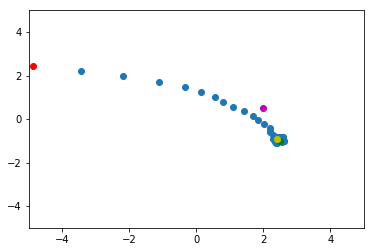

first: [ 2.5 -1. ]
second: [1.5 2. ]
[[2.  0.5]
 [2.  0.5]]


In [101]:
nb = 18
print("target ", targets[:, :, nb])
print("first", goal_types[0, :, nb])
print("second", goal_types[1, :, nb])
plot_trajectory(array_states[:,1,4:6,nb], goal_locations[0, :, nb], v[0, :, nb])
print("first:", goal_locations[0, :, nb])
print("second:", goal_locations[1, :, nb])
print(v[:, :, nb])

In [89]:
np.mean(array_mem_last == 0)

0.0196078431372549

In [90]:
np.mean(array_states[-1, 2:, 0:2, 1], axis = 0)

array([0., 0.], dtype=float32)

In [91]:
np.mean(array_states[-1, 3:, 0:2, nb], axis = 0)

array([0., 0.], dtype=float32)

In [92]:
np.where((goal_types[0, 0, :] == 1) & (goal_types[1, 0, :] == 1))

(array([], dtype=int64),)

In [93]:
v

array([[[ 2.  , -0.75, -3.  , -0.75, -0.25,  2.5 , -0.75, -0.25,  2.  ,
          2.5 ,  2.  ,  2.  , -0.25, -0.25, -0.25, -0.25,  2.5 , -0.25,
         -0.75, -0.75,  2.5 ,  1.5 , -0.25,  2.  , -3.  ,  2.5 , -3.  ,
         -0.75,  2.  , -0.25,  2.  ,  2.  ,  2.  , -3.  ,  2.  ,  1.5 ,
         -0.75,  1.5 ,  1.5 ,  2.  , -0.75, -3.  , -0.25, -3.  , -0.25,
         -0.25, -0.25,  2.  , -0.25,  2.  , -0.25,  2.5 , -0.75,  2.  ,
          2.5 ,  2.5 , -0.25, -0.75, -0.25, -0.25,  2.5 , -0.75,  1.5 ,
         -0.25,  2.5 , -3.  , -0.75, -3.  ,  2.  ,  2.  , -0.75,  2.5 ,
         -0.75, -0.75, -0.25,  2.5 ,  1.5 , -3.  ,  1.5 , -0.25,  2.5 ,
          2.  , -0.25, -0.25, -0.75,  1.5 ,  2.  , -0.25, -0.75,  2.  ,
         -3.  , -0.25, -0.75,  2.  ,  2.  ,  2.  ,  2.  , -3.  ,  1.5 ,
         -0.25],
        [ 0.5 , -0.5 , -3.  , -0.5 , -2.  , -1.  , -0.5 , -2.  ,  0.5 ,
         -1.  ,  0.5 ,  0.5 , -2.  , -2.  , -2.  , -2.  , -1.  , -2.  ,
         -0.5 , -0.5 , -1.  ,  2.  , -2.  ,  0.

In [94]:
vv = np.mean(goal_locations, axis = 0)

In [95]:
v = np.tile(vv, (2, 1, 1))

In [165]:
np.mean(array_states[0, 3:, 0:2, 1], axis = 0)

array([ 0.25, -0.75], dtype=float32)

In [166]:
array_states.

SyntaxError: invalid syntax (<ipython-input-166-2e5bb8609410>, line 1)

In [209]:
array_states[-1, 0,0:2,nb]

array([ 5.843392, -7.008334], dtype=float32)

In [19]:
full_goals[:, :, 45]

array([[ 1.        ,  0.        ,  0.        ,  0.58468604,  3.1692955 ,
         0.        ,  1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  1.3187793 , -0.6615655 ,
         1.        ,  0.        ,  0.        ]], dtype=float32)

In [22]:
goal_locations[:, :, 45]

array([[ 0.58468605,  3.16929552],
       [ 1.31877935, -0.66156551]])

In [25]:
targets[:, :, 45]

array([[1],
       [0]])

In [27]:
goal_types[:, :, 45]

array([[1., 0., 0.],
       [0., 1., 0.]])

In [31]:
array_states[-1, 2:, :, 45]

array([[ 0.58468604,  3.1692955 ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [ 1.3187793 , -0.6615655 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [-0.98659277, -3.7688777 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [102]:
goal_types.shape

(3, 3, 100)

In [103]:
goal_locations.shape

(3, 2, 100)

In [113]:
positions_landmarks = np.array([[[-4 for i in range(100)], [-4 for i in range(100)]], [[4 for i in range(100)], [4 for i in range(100)]], [[-2 for i in range(100)], [0 for i in range(100)]]])

In [117]:
positions_landmarks[2, :, 0]

array([-2,  0])

In [118]:
goal_types = np.array([[[1 for i in range(100)], [0 for i in range(100)], [0 for i in range(100)]], [[1 for i in range(100)], [0 for i in range(100)], [0 for i in range(100)]], [[1 for i in range(100)], [0 for i in range(100)], [0 for i in range(100)]]])

In [119]:
goal_types.shape

(3, 3, 100)

In [120]:
goal_types[0, :, 0]

array([1, 0, 0])

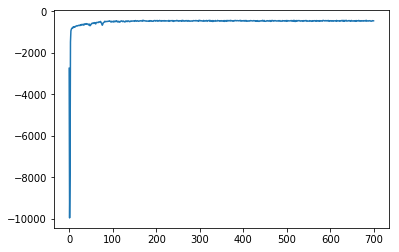

In [56]:
plt.plot(exp.reward_history)
plt.show()

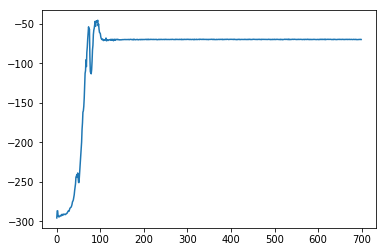

In [55]:
plt.plot(exp.voc_reward_history)
plt.show()

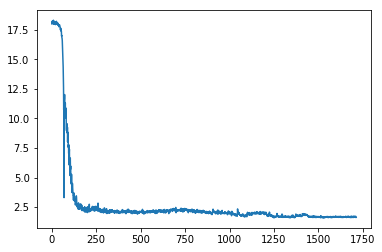

In [102]:
plt.plot(exp.mean_act_count)
plt.show()

In [25]:
exp.mean_act_count[-1]

2.98

In [53]:
array_outputs[-1, :, :, 50]

array([[0.00478059, 0.02923876],
       [4.41817   , 4.4507103 ]], dtype=float32)

In [54]:
goal_locations[:, :, 50]

array([[0, 0],
       [4, 4]])

In [55]:
targets[:, :, 50]

array([[0],
       [1]])

In [64]:
exp.reward_batch_history[-1][:, 50]

array([-0.029627  , -0.61482185], dtype=float32)

In [65]:
np.sqrt(np.sum((array_outputs[-1, [0, 1], :, 50] - goal_locations[[0, 1], :, 50])**2, axis = 1))

array([0.029627  , 0.61482184])

In [58]:
np.mean(array_outputs[-1, :, :, :], axis = 2)

array([[4.7789516, 1.2834195],
       [4.017225 , 1.3816243]], dtype=float32)

In [59]:
v = np.sum(np.sum(array_outputs[-1, :, :, :], axis = 2), axis = 0)/200

In [60]:
np.max(array_outputs[-1, :, :, :], axis = 2)

array([[8.406772 , 4.3033895],
       [8.583255 , 4.4507103]], dtype=float32)

In [61]:
np.min(array_outputs[-1, :, :, :], axis = 2)

array([[-0.05605835, -0.26878864],
       [-0.06561816, -0.35824925]], dtype=float32)

In [62]:
np.std(array_outputs[-1, :, :, :], axis = 2)

array([[3.209854 , 1.8657004],
       [3.2325075, 1.9222469]], dtype=float32)

In [303]:
sum((goal_locations[:, 1, :] == 0).sum(axis = 1))/200

0.655

In [98]:
plx = np.ones((2, 1, 100))*4
ply = np.ones((2, 1, 100))*2.28
pl = np.concatenate([plx, ply], axis = 1)
np.mean(np.sum(np.sqrt(np.sum((pl - goal_locations)**2, axis = 1)), axis = 0))

3.7380105721219263

In [99]:
plx = np.ones((2, 1, 100))*4
ply = np.ones((2, 1, 100))*1.33
pl = np.concatenate([plx, ply], axis = 1)
np.mean(np.sum(np.sqrt(np.sum((pl - goal_locations)**2, axis = 1)), axis = 0))

3.75172211500846

In [107]:
plx = np.ones((3, 1))*4
ply = np.ones((3, 1))*2.28
pl = np.concatenate([plx, ply], axis = 1)
np.mean(np.sqrt(np.sum((pl - array_states[-1, 2:, 0:2, 14])**2, axis = 1)))

3.642781347408684

In [108]:
plx = np.ones((3, 1))*4
ply = np.ones((3, 1))*1.33
pl = np.concatenate([plx, ply], axis = 1)
np.mean(np.sqrt(np.sum((pl - array_states[-1, 2:, 0:2, 14])**2, axis = 1)))

3.700211538103295

In [15]:
exp.goal_locations

<tf.Tensor 'Placeholder_5:0' shape=(3, 2, 100) dtype=float32>

In [175]:
pred_reward

NameError: name 'pred_reward' is not defined

In [87]:
pred[-1, :, :, 10]

array([[ 7.6263475 , -0.17130268],
       [ 3.2847695 ,  3.8299196 ]], dtype=float32)

In [83]:
goal_locations[:, :, 10]

array([[4, 4],
       [8, 0]])

In [82]:
targets[:, :, 73]

array([[1],
       [0]])

In [296]:
length = []
for i in range(100):
    length.append(len(np.unique(np.argmax(array_utterances[:, 0, :, i], axis = 1))))
    length.append(len(np.unique(np.argmax(array_utterances[:, 1, :, i], axis = 1))))

In [297]:
np.median(length)

15.0

In [285]:
array_utterances.shape

(51, 2, 20, 100)

In [20]:
len(np.unique(np.argmax(array_utterances[:, 0, :, 10], axis = 1)))

2

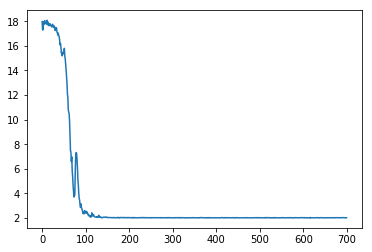

In [53]:
plt.plot(exp.mean_act_count)
plt.show()

In [90]:
goal_locations[:, :, 0]

array([[4, 4],
       [8, 0]])

In [92]:
goal_locations[:, :, 2]

array([[4, 4],
       [8, 0]])

In [102]:
goal_locations[:, :, 5]

array([[0, 0],
       [4, 4]])

In [94]:
np.argmax(array_utterances[:, 0, :, 0], axis = 1)

array([ 0,  0,  0,  3, 17, 17,  0,  3,  0,  3,  0,  0,  9,  0,  3,  3,  3,
       18,  3,  0,  3,  0,  0,  0,  0,  3,  3,  3,  3,  7,  0,  0,  9,  0,
        0,  3,  3,  3,  3,  0,  3,  3,  3,  3, 10,  9,  7,  3,  3, 15,  0])

In [95]:
np.argmax(array_utterances[:, 0, :, 2], axis = 1)

array([ 0, 10,  0,  0,  0,  0,  3,  3,  9,  0,  0,  3, 13,  3,  0,  3,  0,
        0,  3,  3,  3,  9,  0,  3,  9,  7,  9,  0,  3,  4,  4,  0,  3,  9,
       14,  0,  3,  0,  0,  0,  3,  0,  0,  9,  3,  0,  0,  0,  3,  3,  3])

In [122]:
np.argmax(array_utterances[:, 1, :, 5], axis = 1)

array([ 0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  3,  0,  0,  0,  8,  0,  0,
        0,  6,  3,  0,  0,  0,  0,  3,  0,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 10,  0,  0,  0,  3,  0,  0,  3,  3,  0,  0,  0,  3])

In [99]:
np.unique(np.argmax(array_utterances, axis = 2))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [123]:
exp.voc_reward_history

[]

In [46]:
np.unique(np.argmax(array_utterances, axis = 2)[:, :, 0])

array([ 0,  2,  3,  4,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19])

In [51]:
np.unique(np.argmax(array_utterances, axis = 2)[:, 0, 10])

array([ 0, 15, 18])

In [55]:
np.unique(np.argmax(array_utterances, axis = 2)[:, 1, 11])

array([ 0, 15, 18])

In [145]:
np.unique(np.argmax(array_utterances, axis = 2)[:, 0, 12])

array([ 0,  5,  9, 16, 17, 18, 19])

In [146]:
np.unique(np.argmax(array_utterances, axis = 2)[:, 1, 12])

array([ 0,  2,  4,  5,  9, 10, 18, 19])

In [139]:
goal_locations[:, :, 25]

array([[0, 0],
       [4, 4]])

In [142]:
np.argmax(array_utterances, axis = 2)

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[17,  5,  5, ..., 12,  6,  5],
        [ 6,  5,  6, ...,  5,  6,  2]],

       [[ 6,  5, 19, ..., 18,  2,  5],
        [ 6,  5, 17, ...,  5,  6, 18]],

       ...,

       [[11,  9,  0, ...,  8,  6,  5],
        [ 6,  5,  6, ...,  5,  6,  9]],

       [[19, 19, 19, ...,  9, 19,  5],
        [ 6,  7,  6, ...,  5,  6,  6]],

       [[16,  5, 11, ..., 14,  6,  5],
        [ 6,  5,  6, ...,  5,  2, 19]]])

In [319]:
array_pred

NameError: name 'array_pred' is not defined

In [322]:
150/9

16.666666666666668

In [334]:
150/17

8.823529411764707

In [57]:
pred[-1, 1, :, 10]

array([-3.6868453e-04,  9.9153298e-01, -2.8760213e-02,  3.8191910e+00,
        4.0793910e+00,  5.5776936e-01,  5.0881344e-01,  3.6988370e-02],
      dtype=float32)

In [58]:
full_goals[1, :, 10]

array([0., 1., 0., 4., 4., 1., 0., 0.], dtype=float32)

In [43]:
full_goals.shape

(2, 8, 100)

In [48]:
np.sum(exp.array_utt[-1], axis = (0, 1, 3))/np.sum(exp.array_utt[-1])

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04,
       0.000e+00, 0.000e+00, 3.940e-01, 0.000e+00, 0.000e+00, 0.000e+00,
       3.432e-01, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 2.626e-01,
       0.000e+00, 0.000e+00], dtype=float32)

In [234]:
np.sum(exp.array_utt[-23], axis = (0, 1, 3))

array([7.00e+00, 3.00e+00, 2.00e+00, 8.00e+00, 4.00e+00, 7.00e+00,
       2.00e+00, 6.20e+01, 3.00e+01, 1.00e+00, 9.81e+03, 1.10e+01,
       0.00e+00, 1.00e+01, 1.20e+01, 4.00e+00, 1.20e+01, 6.00e+00,
       5.00e+00, 4.00e+00], dtype=float32)

In [97]:
exp.mean_act_count[-4]

2.24

In [115]:
exp.reward_history[-3]

-661.3527

In [125]:
v = tf.Variable(np.sum(exp.array_utt[-3], axis = (0, 1, 3)))
u = tf.gather(v, tf.where(tf.not_equal(v, 0)))
init = tf.global_variables_initializer()

In [126]:
with tf.Session() as sess:
    sess.run(init)
    ee = sess.run(u)

In [134]:
ee

array([[7.000e+00],
       [8.000e+00],
       [4.220e+03],
       [5.000e+00],
       [5.000e+00],
       [4.000e+00],
       [1.800e+01],
       [5.000e+00],
       [1.410e+03],
       [6.000e+00],
       [6.000e+00],
       [2.000e+00],
       [5.000e+00],
       [3.000e+00],
       [5.900e+01],
       [7.000e+00],
       [7.000e+00],
       [2.117e+03],
       [2.106e+03]], dtype=float32)

In [73]:
len(exp.voc_reward_history)

161

In [193]:
1/0.00000001

100000000.0

In [30]:
np.argmax(array_utterances, axis = 2)[:, 0, 40]

array([ 0,  7,  7,  7,  8, 15,  8,  8,  8, 15,  8,  8,  7,  7, 15, 15, 15,
        8,  7,  7,  7,  8, 15,  7,  7,  7,  8,  8,  8, 15,  8,  7,  8,  7,
        7, 15,  7,  7,  8,  7, 15,  8, 15,  8,  8,  8,  7, 15,  7,  8,  7,
        8,  7, 15,  8,  7,  7, 15,  8, 15,  8, 15,  8,  8,  7,  7,  8,  8,
        7,  8, 15, 15,  8, 15,  8,  7,  7, 15,  7,  8,  8, 15, 15, 15,  7,
       15,  7,  7, 15,  7, 15,  8,  8,  7, 15, 15, 15,  8,  7,  8,  8,  8,
        8,  7, 15, 15, 15,  8,  7, 15,  7, 15,  7,  8,  8,  8,  7, 15,  7,
       15, 15,  7,  8,  8,  8, 15, 15, 15, 15,  7,  7, 15,  7, 15,  8,  8,
        8, 15,  8, 15, 15,  8,  8,  8,  7, 15,  7, 15,  7,  8,  8, 15,  7,
        7,  8,  7,  7, 15,  7,  8,  8,  7,  7, 15,  7,  8,  8,  7,  7, 15,
       15,  8, 15,  7,  7,  8,  7,  8, 15, 15,  7, 15,  7, 15,  8, 15,  8,
       15,  8, 15,  8,  8,  8, 15,  7, 15,  7,  7,  7, 15,  8])

In [66]:
goal_locations[:, :, 32]

array([[4, 4],
       [0, 0]])

In [26]:
goal_locations[:, :, 13]

array([[-1.57926386,  1.09727604],
       [-1.57926386,  1.09727604]])

In [27]:
full_goals[:, :, 40]

array([[1.        , 0.        , 0.        , 0.48238987, 0.9266134 ,
        1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.45202035, 1.5437603 ,
        0.        , 1.        , 0.        ]], dtype=float32)

In [94]:
exp.grads_norm

[]

In [32]:
u = tf.Variable(0.0)
init = tf.global_variables_initializer()
v = tf.log(u)

In [33]:
with tf.Session() as sess:
    sess.run(init)
    ee = sess.run(v)

In [34]:
ee

-inf

In [27]:
np.log(0.000000000001)

-27.631021115928547

In [107]:
goal_types[:, :, 100]

IndexError: index 100 is out of bounds for axis 2 with size 100

In [18]:
np.unique(np.argmax(array_utterances[1:, :, :, :], axis = 2))

array([12, 13, 16])

In [11]:
landmark_nb = [np.random.choice(3, (2, 1), replace = True) for _ in range(FLAGS.batch_size)]
landmark_nb_batch = np.stack(landmark_nb, axis = 2)

In [18]:
landmark_nb[11]

array([[1],
       [0]])

In [19]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [210]:
full_goals[:, 3:6, 2]

array([[0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [208]:
goal_locations[:, :, 62]

array([[-0.20028409, -0.96775521],
       [ 0.86976883,  0.97217373]])

In [257]:
array_states[0, 2:, :, 36]

array([[ 0.10546685, -0.38599977,  0.        ,  0.        ,  1.4818624 ,
        -0.6813463 ,  1.        ,  0.        ,  0.        ],
       [-0.23637994,  0.06048546,  0.        ,  0.        ,  1.9055567 ,
         1.469917  ,  0.        ,  1.        ,  0.        ],
       [-0.2568565 , -0.13294637,  0.        ,  0.        , -1.2636497 ,
        -0.06211003,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [30]:
np.argmax(array_utterances[:, 1, :, 2], axis = 1)

array([ 0, 17, 17,  5, 17,  5,  5,  5, 17, 17, 17, 17,  5, 17,  5,  5, 17,
       17, 17,  5, 17,  5, 17, 17, 17, 17, 17,  5, 17, 17, 17,  5,  5,  5,
        5,  5, 17,  5, 17,  5,  5,  5, 17, 17,  5, 17,  5,  5,  5,  5,  5])

In [253]:
full_goals[:, :, 10]

array([[1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0.]], dtype=float32)

In [40]:
goal_locations[:, :, 10]

array([[ 1.5, -0.5],
       [-1. , -1. ]])

In [39]:
goal_locations[:, :, 10]

array([[ 1.5, -0.5],
       [-1. , -1. ]])

In [36]:
full_goals[:, :, 10]

array([[ 0. ,  1. ,  0. ,  1.5, -0.5,  0. ,  1. ,  0. ],
       [ 0. ,  1. ,  0. , -1. , -1. ,  1. ,  0. ,  0. ]], dtype=float32)

In [43]:
targets[:, : ,10]

array([[1],
       [0]])

In [104]:
pred[-1, :, :, 10]

array([[ 6.0697347e-03,  1.0513390e+00,  2.2460965e-02,  2.4765704e+00,
        -1.0961896e+00,  5.0263029e-01,  4.7486654e-01, -3.6538243e-03],
       [-4.0758252e-03,  1.0102042e+00, -2.4224397e-02, -3.0727093e+00,
        -3.0304856e+00,  5.5312365e-01,  4.2007229e-01,  2.5203116e-03]],
      dtype=float32)

In [52]:
array_states[-1, 2:, :, 18]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [-1. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 1.5, -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]],
      dtype=float32)

In [60]:
goal_types[:, :, 45]

array([[0, 1, 0],
       [0, 1, 0]])

In [113]:
goal_locations[:,:, 12]

array([[-3. , -3. ],
       [ 2.5, -1. ]])

In [114]:
np.argmax(array_utterances[:, 0, :, 12], axis = 1)

array([0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5])

In [111]:
targets[:, :, 10]

array([[1],
       [0]])